In [2]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('poster')
sns.set_style('white')
%matplotlib inline

In [16]:
X = np.array([list('MLVK'),
              list('MKVR'),
              list('MLVR'),
              list('MKVK'),
              list('MLVK'),])
X.shape

(5, 4)

In [17]:
Y = np.array([[1],
              [0],
              [0.1],
              [0.9],
              [0.05]])
Y.shape

(5, 1)

In [142]:
n_measures = 4
geno1_folds = np.random.normal(loc=5, scale=0.5, size=n_measures)
geno2_folds = np.random.normal(loc=7, scale=0.6, size=n_measures+5)
geno3_folds = np.random.normal(loc=10, scale=0.2, size=n_measures-2)

In [143]:
geno1_folds

array([ 4.41584601,  4.79890996,  5.25500946,  5.95498411])

In [144]:
geno2_folds

array([ 6.96576017,  7.33083307,  6.65489756,  6.42604332,  5.74417822,
        5.88012385,  7.70018396,  7.45405359,  7.65575332])

In [145]:
geno3_folds

array([ 10.11936343,  10.08910662])

In [146]:
with pm.Model() as model:
    
    mus = pm.Flat('mus') # Master "mu" for hierarchical model.
    sds = pm.Uniform('sds', lower=0, upper=10)
    lam = pm.Uniform('lam', lower=0, upper=10)
    
    mu1 = pm.Normal('mu1', mu=mus, sd=sds)
    sd1 = pm.Exponential('sd1', lam=lam)
    mu2 = pm.Normal('mu2', mu=mus, sd=sds)
    sd2 = pm.Exponential('sd2', lam=lam)
    mu3 = pm.Normal('mu3', mu=mus, sd=sds)
    sd3 = pm.Exponential('sd3', lam=lam)
    geno1_like = pm.Normal('geno1', mu=mu1, sd=sd1, observed=geno1_folds)
    geno2_like = pm.Normal('geno2', mu=mu2, sd=sd2, observed=geno2_folds)
    geno3_like = pm.Normal('geno3', mu=mu3, sd=sd3, observed=geno3_folds)

Applied interval-transform to sds and added transformed sds_interval_ to model.
Applied interval-transform to lam and added transformed lam_interval_ to model.
Applied log-transform to sd1 and added transformed sd1_log_ to model.
Applied log-transform to sd2 and added transformed sd2_log_ to model.
Applied log-transform to sd3 and added transformed sd3_log_ to model.


In [149]:
with model:
    params = pm.variational.advi(n=120000)
    trace = pm.variational.sample_vp(params, draws=2000)

Iteration 0 [0%]: ELBO = -53852.11
Iteration 12000 [10%]: Average ELBO = -13011.67
Iteration 24000 [20%]: Average ELBO = -48.32
Iteration 36000 [30%]: Average ELBO = -34.46
Iteration 48000 [40%]: Average ELBO = -31.11
Iteration 60000 [50%]: Average ELBO = -29.28
Iteration 72000 [60%]: Average ELBO = -27.67
Iteration 84000 [70%]: Average ELBO = -26.55
Iteration 96000 [80%]: Average ELBO = -25.93
Iteration 108000 [90%]: Average ELBO = -25.72
Finished [100%]: Average ELBO = -25.73


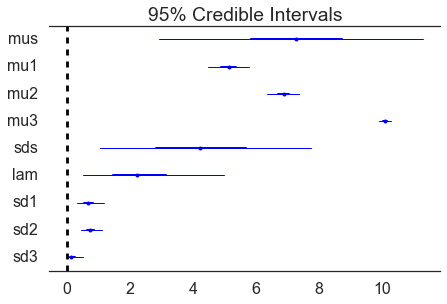

In [150]:
pm.forestplot(trace)